In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from fitting_functions import *
import glob
from astropy.constants import c
from astropy.io import ascii
import astropy.units as u
from Borg_emission_lines import lines
import pickle
import random
import pprint
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
os.chdir('c:\\Users\\isaia\\Downloads')
os.getcwd()

'c:\\Users\\isaia\\Downloads'

In [6]:
borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']


In [ ]:
file_spec = 'spectra_13Dec2024_full.p'
with open(file_spec, 'rb') as file:
    data_spec = pickle.load(file)

'''
example_galaxy = list(data.keys())[0]
if isinstance(data[example_galaxy], dict):
    print("Column keys:", data[example_galaxy].keys())
    # Peek at values
    for k in data[example_galaxy].keys():
        print(f"{k}: {data[example_galaxy][k]}")
'''

borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']



tab = ascii.read('highz_msaid_public.dat')
all_fit_results = []

for idx, gal in enumerate(borg_ids):
    itab = np.where(tab['msaid'] == gal)[0]
    z = tab['z'][itab][0]
    print(gal, z)
    print(data_spec[gal]['prism-clear'])

    wavelength = data_spec[gal]['prism-clear']['lam']*1e4 #converting to \AA    
    flux_nu = data_spec[gal]['prism-clear']['flux'] #f_nu 
    # print(flux_nu)
    flux_nu_err = data_spec[gal]['prism-clear']['err']

    flux_l = convert_fnu_to_flambda(wavelength, flux_nu) * 1.e20  # convert units to 1e-20 in cgs.
    # print(flux_l/1e20)
    
    flux_l_err = convert_fnu_to_flambda(wavelength, flux_nu_err) * 1.e20

    # select indices in wavelength array that correspond to our selected wavelength range
    redshift_lines = {key: value * (z + 1) for key, value in lines.items()}
    spectral_windows = {
        'CIV_window': [redshift_lines['CIV_doublet'] - 1500, redshift_lines['CIII]_doublet'] + 1500],
        'OII_window': [redshift_lines['[OII]_doublet'] - 1500, redshift_lines['Hgammma_OIII'] + 1500],
        'Hb_OIII_window': [redshift_lines['Hbeta'] - 1500, redshift_lines['[OIII]_5007'] + 1500]
    }

    # Begin bootstrap sampling:
    N = 100
    bootstrap_results = {
        'continuum_slope': [],
        'continuum_intercept': [],
        'line_fluxes': [],  # List of dictionaries, one per iteration
        'flux_ratios': [],  # List of dictionaries, one per iteration
        'amplitudes': [],   # Add amplitudes to the dictionary
        'widths': []        # Add widths to the dictionary
    }   
    count=0
    for _ in range(N):  # loop over the noise and then get the windows, and at every iteration compute the line fluxes and ratios
        count+=1
        # Generate new spectrum by adding Gaussian noise
        flux_new = flux_l + np.random.normal(0, flux_l_err)

        # Dictionary to store this iteration's line fluxes
        iteration_fluxes = {}
        iteration_ratios = {}
        iteration_amplitudes = {}
        iteration_widths = {}

        for window_name, window_range in spectral_windows.items():
            sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
            window_wavelength = wavelength[sliced_index]
            window_flux = flux_l[sliced_index]
            window_flux_err = flux_l_err[sliced_index]
            invalid_spec = np.where((np.isfinite(window_flux) == False) | (np.isfinite(window_flux_err) == False))
            window_flux[invalid_spec] = 0.
            window_flux_err[invalid_spec] = 1.e20
     
            model = models.Polynomial1D(1)
            Nlines = 0

            for key in redshift_lines:
                lam = redshift_lines[key]
                if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                    continue

                line = models.Gaussian1D(amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                                         mean=lam, stddev=60)
                line.amplitude.min = 0.  # 1.e-3
                line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                line.amplitude.fixed = False
                line.stddev.min = 0.  # 1.e-3
                line.stddev.fixed = False
                model += line
                Nlines += 1

            # Fit model:
            fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
            g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
            # Check fit status using fit_info
            status = fit_g.fit_info.get('status')

           
            # Store bootstrapped parameters for this iteration
            bootstrap_results['continuum_slope'].append(g.parameters[0])  # Use g.parameters[0] for the slope (c0)
            bootstrap_results['continuum_intercept'].append(g.parameters[1])  # Use g.parameters[1] for the intercept (c1)


            #for line_name, lam in redshift_lines.items():
            for i, line_name in enumerate([key for key in redshift_lines if redshift_lines[key] >= np.nanmin(window_wavelength) and redshift_lines[key] <= np.nanmax(window_wavelength)]):

                #print(line_name)
                amp = getattr(g, f'amplitude_{i+1}').value
                width = getattr(g, f'stddev_{i+1}').value

                # Store in dictionaries for later error calculation
                if line_name not in iteration_amplitudes:
                    iteration_amplitudes[line_name] = []
                    iteration_widths[line_name] = []

                iteration_amplitudes[line_name].append(amp)
                iteration_widths[line_name].append(width)

                # **Compute line flux**
                flux = amp * width * np.sqrt(2 * np.pi)
                iteration_fluxes[f"{line_name}_flux"] = flux
            # print(count) #correctly goes throush the 3 spectral windows and finds fluxes for all lines, this for 100 times


        # **Compute flux ratios**
        # print(iteration_fluxes) #Fluxes saved correctly! No overwritting
        if '[NeIII]_flux' in iteration_fluxes and '[OII]_doublet_flux' in iteration_fluxes:
            iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']

        if '[OIII]_5007_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
            iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']

        if 'Hdelta_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
            iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']

        if 'Hgammma_OIII_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
            iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']



        # Debugging: Print ratios for each iteration
        #print(f"Iteration {count} flux ratios: {iteration_ratios}") This worked!

        # Store this bootstrap iteration's results
        bootstrap_results['line_fluxes'].append(iteration_fluxes)
        bootstrap_results['flux_ratios'].append(iteration_ratios)
        bootstrap_results['amplitudes'].append(iteration_amplitudes)
        bootstrap_results['widths'].append(iteration_widths)

    # Now that all bootstrap iterations are done, plot and save the fit for each spectral window
    for window_name, window_range in spectral_windows.items():
        sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
        window_wavelength = wavelength[sliced_index]
        window_flux = flux_l[sliced_index]
        window_flux_err = flux_l_err[sliced_index]

        # Define the model and fit it
        model = models.Polynomial1D(1)
        Nlines = 0

        for key in redshift_lines:
            lam = redshift_lines[key]
            if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                continue

            line = models.Gaussian1D(
                amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                mean=lam, stddev=60
            )
            line.amplitude.min = 0.
            line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
            model += line
            Nlines += 1

        # Fit the model to the spectrum
        fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
        g = fit_g(model, window_wavelength, window_flux, weights=1 / window_flux_err, maxiter=10000, estimate_jacobian=True)

        # Plot and save the fit for each spectral window
        fig = plt.figure(figsize=(7, 7))
        plt.title(gal + " - " + window_name, fontsize=16)
        plt.step(window_wavelength, window_flux, where='mid', color='k', label='Data')  # Original data
        plt.step(window_wavelength, window_flux_err, where='mid', color='grey', linestyle='dotted', label='Error')  # Error bars
        residuals = window_flux - g(window_wavelength)  # Residuals
        plt.step(window_wavelength, residuals, where='mid', color='orange', label='Residuals')  # Residuals
        plt.plot(window_wavelength, g(window_wavelength), color='red', label='Fit')  # Model fit

        plt.xlabel(r"Wavelength ($\AA$)", fontsize=18)
        plt.ylabel(r"Flux (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        # Save the plot as a PNG (or any other format)
        plot_filename = f"Figures_spectra/fit_{gal}_{window_name}.png"
        plt.savefig(plot_filename)  # Save the figure with a unique filename based on the window name

        plt.close()  # Close the plot after saving

    # **Compute Errors from Bootstrap Samples**
    final_results = {}  # Reset for each galaxy!

    # **Find all emission lines across bootstraps**
    all_detected_lines = set()
    for iteration in bootstrap_results['line_fluxes']:
        all_detected_lines.update(iteration.keys())  # Collect all line_flux keys

    # **Compute errors for all detected lines**
    for line in all_detected_lines:
        flux_values = [iteration[line] for iteration in bootstrap_results['line_fluxes'] if line in iteration]
        if len(flux_values) > 0:  # Ensure at least one detection
            flux_16, flux_median, flux_84 = np.percentile(flux_values, [16, 50, 84])
            final_results[line] = flux_median
            final_results[f"{line}_err"] = np.array([flux_median - flux_16, flux_84 - flux_median])  # Asymmetric errors

   
    # **Compute errors for flux ratios**
    for ratio in ['NeIII_OII_ratio', 'OIII5007_Hbeta_ratio','Hdelta_Hbeta_ratio','Hgamma_Hbeta_ratio']:
        ratio_values = [iteration[ratio] for iteration in bootstrap_results['flux_ratios'] if ratio in iteration]
        if len(ratio_values) > 0:
            ratio_16, ratio_median, ratio_84 = np.percentile(ratio_values, [16, 50, 84])
            final_results[ratio] = ratio_median
            final_results[f"{ratio}_err"] = np.array([ratio_median - ratio_16, ratio_84 - ratio_median])  

    # Append results **per galaxy**
    all_fit_results.append({gal: final_results})
    print(f"Final results for {gal}:", final_results.keys())

print("Final results before saving:", final_results.keys())

# Save fit results
with open('fit_results_ratios.pkl', 'wb') as f:
    pickle.dump(all_fit_results, f)



2426_112 7.337
{'lam': array([0.58      , 0.58368511, 0.58743788, 0.59126022, 0.59515426,
       0.59912194, 0.60316525, 0.60728664, 0.61148833, 0.61577259,
       0.62014179, 0.62459864, 0.62914577, 0.63378584, 0.63852165,
       0.6433561 , 0.6482922 , 0.65333313, 0.6584822 , 0.66374277,
       0.66911831, 0.67461243, 0.68022885, 0.68597146, 0.69184423,
       0.6978513 , 0.70399693, 0.71028561, 0.71672191, 0.72331053,
       0.73005628, 0.73696412, 0.7440392 , 0.75128688, 0.75871251,
       0.76632159, 0.77411992, 0.7821132 , 0.79030739, 0.79870847,
       0.80732254, 0.81615575, 0.82521435, 0.83450455, 0.8440326 ,
       0.85380473, 0.8638271 , 0.87410579, 0.88464675, 0.89545572,
       0.90653824, 0.9178996 , 0.92954474, 0.94147818, 0.95370401,
       0.96622584, 0.97904675, 0.99216917, 1.00559465, 1.01932434,
       1.03335816, 1.04769562, 1.06233481, 1.07727331, 1.09250762,
       1.10803299, 1.12384392, 1.13993392, 1.15629547, 1.17292011,
       1.18979848, 1.20692039, 1.224274

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


Final results for 2426_112: dict_keys(['[OIII]_4959_flux', '[OIII]_4959_flux_err', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OII]_doublet_flux', '[OII]_doublet_flux_err', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'MgI_5174_flux', 'MgI_5174_flux_err', 'Hbeta_flux', 'Hbeta_flux_err', '[NeIII]_flux', '[NeIII]_flux_err', 'Hdelta_flux', 'Hdelta_flux_err', 'Hepsilon_flux', 'Hepsilon_flux_err', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbeta_ratio_err'])
2426_1736 7.822
{'lam': array([0.58      , 0.58368511, 0.58743788, 0.59126022, 0.59515426,
       0.59912194, 0.60316525, 0.60728664, 0.61148833, 0.61577259,
       0.62014179, 0.62459864, 0.62914577, 0.63378584, 0.63852165,
       0.6433561 , 0.6482922 , 0.65333313, 0.

C:\Users\isaia\AppData\Local\Temp\ipykernel_20180\4210931853.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_20180\4210931853.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_20180\4210931853.py:133: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_20180\4210931853.py:136: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\

Final results for 2426_1130: dict_keys(['[OIII]_4959_flux', '[OIII]_4959_flux_err', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OII]_doublet_flux', '[OII]_doublet_flux_err', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'Hbeta_flux', 'Hbeta_flux_err', '[NeIII]_flux', '[NeIII]_flux_err', 'Hdelta_flux', 'Hdelta_flux_err', 'Hepsilon_flux', 'Hepsilon_flux_err', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbeta_ratio_err'])
2426_1777 8.44
{'lam': array([0.58      , 0.58368511, 0.58743788, 0.59126022, 0.59515426,
       0.59912194, 0.60316525, 0.60728664, 0.61148833, 0.61577259,
       0.62014179, 0.62459864, 0.62914577, 0.63378584, 0.63852165,
       0.6433561 , 0.6482922 , 0.65333313, 0.6584822 , 0.66374277,
       0.6691183

In [44]:
with open('C:/Users/isaia/Downloads/fit_results_ratios.pkl', 'rb') as f:
    BoRG_survey_results = pickle.load(f)

In [45]:
BoRG_survey_results

[{'2426_112': {'CIV_doublet_flux': 339.0077221136103,
   'CIV_doublet_flux_err': array([339.00772211, 203.70628006]),
   'Hepsilon_flux': 183.7997419786788,
   'Hepsilon_flux_err': array([52.62668757, 60.48447616]),
   'Hgammma_OIII_flux': 346.8540580044212,
   'Hgammma_OIII_flux_err': array([133.64948396,  56.40831204]),
   'MgI_5174_flux': 0.0,
   'MgI_5174_flux_err': array([ 0.        , 36.56803228]),
   'Hdelta_flux': 88.95432973048213,
   'Hdelta_flux_err': array([20.11413938, 29.73051479]),
   'CIII]_doublet_flux': 484.0966214755799,
   'CIII]_doublet_flux_err': array([45.66238509, 71.04751524]),
   'OIII]_doublet_flux': 0.0,
   'OIII]_doublet_flux_err': array([  0.        , 438.44507353]),
   '[OIII]_4959_flux': 654.9642992853801,
   '[OIII]_4959_flux_err': array([78.60774215, 50.37815714]),
   '[OIII]_5007_flux': 1956.67771095657,
   '[OIII]_5007_flux_err': array([93.3557928 , 81.76036894]),
   '[NeIII]_flux': 361.6270438472362,
   '[NeIII]_flux_err': array([69.78363442, 95.303

In [47]:
galaxy_ids = []
for i in range(len(BoRG_survey_results)):
    galaxy_ids.append(list(BoRG_survey_results[i].keys()))


In [49]:
def grab_data(galaxy, data):
    g_id = list(galaxy.keys())[0] 
    return galaxy[g_id].get(data, np.nan)

# Use the keys from the first galaxy in BoRG_survey_results
first_galaxy = BoRG_survey_results[0]
first_gal_id = list(first_galaxy.keys())[0]
data_keys = first_galaxy[first_gal_id].keys()

data_dict = {key: [] for key in data_keys}
for galaxy in BoRG_survey_results: 
    for key in data_dict:
        data_dict[key].append(grab_data(galaxy, key))

# Save to dataframe
BoRG_df = pd.DataFrame(data_dict)

In [50]:
BoRG_df['Galaxy ID'] = galaxy_ids

move_this = BoRG_df.pop('Galaxy ID')
BoRG_df.insert(0, 'Galaxy ID', move_this)

In [62]:
BoRG_df['NeIII_OII_ratio_log'] = np.log(np.array(BoRG_df['NeIII_OII_ratio']))
BoRG_df['OIII5007_Hbeta_ratio_log'] = np.log(np.array(BoRG_df['OIII5007_Hbeta_ratio']))

BoRG_df[['Galaxy ID', 'NeIII_OII_ratio_log', 'OIII5007_Hbeta_ratio_log']]

,Galaxy ID,NeIII_OII_ratio_log,OIII5007_Hbeta_ratio_log
0,[2426_112],0.880714,1.874680
1,[2426_1736],-0.747828,1.841211
2,[2426_1130],NaN,1.715561
3,[2426_1777],-0.148083,1.686191
4,[2426_169],0.977777,1.669437
5,[2426_1690],NaN,1.709007
6,[2426_1655],-0.704140,1.482270
7,[1747_199],-0.652572,1.565667
8,[1747_732],-0.240542,1.974970
9,[1747_902],-0.681921,1.843318


In [55]:
BoRG_df.columns

Index(['Galaxy ID', 'CIV_doublet_flux', 'CIV_doublet_flux_err',
       'Hepsilon_flux', 'Hepsilon_flux_err', 'Hgammma_OIII_flux',
       'Hgammma_OIII_flux_err', 'MgI_5174_flux', 'MgI_5174_flux_err',
       'Hdelta_flux', 'Hdelta_flux_err', 'CIII]_doublet_flux',
       'CIII]_doublet_flux_err', 'OIII]_doublet_flux',
       'OIII]_doublet_flux_err', '[OIII]_4959_flux', '[OIII]_4959_flux_err',
       '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[NeIII]_flux',
       '[NeIII]_flux_err', '[OII]_doublet_flux', '[OII]_doublet_flux_err',
       'Hbeta_flux', 'Hbeta_flux_err', 'NeIII_OII_ratio',
       'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio',
       'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio',
       'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio',
       'Hgamma_Hbeta_ratio_err'],
      dtype='object')

In [52]:
BoRG_df[['Galaxy ID'] + [col for col in BoRG_df.columns if col.endswith('ratio')]]

,Galaxy ID,NeIII_OII_ratio,OIII5007_Hbeta_ratio,Hdelta_Hbeta_ratio,Hgamma_Hbeta_ratio
0,[2426_112],2.412622,6.518735,0.304422,1.162396
1,[2426_1736],0.473394,6.304167,0.264097,0.370912
2,[2426_1130],NaN,5.559794,0.590548,1.076986
3,[2426_1777],0.862359,5.398877,0.037196,0.633467
4,[2426_169],2.658539,5.309176,0.196375,0.615737
5,[2426_1690],NaN,5.523473,0.000000,0.304732
6,[2426_1655],0.494534,4.402930,0.238576,0.484250
7,[1747_199],0.520705,4.785867,0.115325,0.230260
8,[1747_732],0.786201,7.206407,0.259882,0.674681
9,[1747_902],0.505645,6.317465,0.167534,0.364876


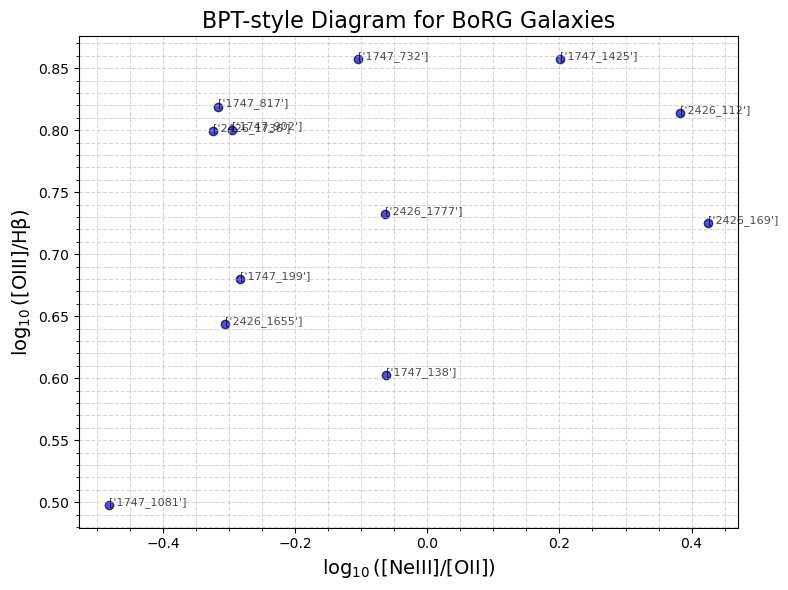

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Example: scatter plot for your ratios
x = BoRG_df['NeIII_OII_ratio']
y = BoRG_df['OIII5007_Hbeta_ratio']
ids = BoRG_df['Galaxy ID']

# Take log10 safely (avoid log of negative/zero)
mask = x > 0  # Only keep valid entries
x_logged = np.log10(x[mask])
y_logged = np.log10(y[mask])
ids_masked = ids[mask]

plt.figure(figsize=(8, 6))
plt.scatter(x_logged, y_logged, color='blue', alpha=0.7, edgecolor='k')

# Annotate each point with its Galaxy ID
for xi, yi, label in zip(x_logged, y_logged, ids_masked):
    plt.annotate(label, (xi, yi), fontsize=8, alpha=0.7)

# Labels and title
plt.xlabel(r'$\log_{10}(\mathrm{[NeIII]/[OII]})$', fontsize=14)
plt.ylabel(r'$\log_{10}(\mathrm{[OIII]/H\beta})$', fontsize=14)
plt.title('BPT-style Diagram for BoRG Galaxies', fontsize=16)

# Grid and axis formatting
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.minorticks_on()

plt.tight_layout()
plt.show()


In [32]:
def process_spectra(gal_ids, lines):
    file_spec = 'spectra_13Dec2024_full.p'
    with open(file_spec, 'rb') as file:
        data_spec = pickle.load(file)

    tab = ascii.read('highz_msaid_public.dat')
    all_fit_results = []

    for idx, gal in enumerate(gal_ids):
        itab = np.where(tab['msaid'] == gal)[0]
        z = tab['z'][itab][0]
        print(gal, z)
        print(data_spec[gal]['prism-clear'])

        wavelength = data_spec[gal]['prism-clear']['lam'] * 1e4
        flux_nu = data_spec[gal]['prism-clear']['flux']
        flux_nu_err = data_spec[gal]['prism-clear']['err']

        flux_l = convert_fnu_to_flambda(wavelength, flux_nu) * 1.e20
        flux_l_err = convert_fnu_to_flambda(wavelength, flux_nu_err) * 1.e20

        redshift_lines = {key: value * (z + 1) for key, value in lines.items()}
        spectral_windows = {
            'CIV_window': [redshift_lines['CIV_doublet'] - 1500, redshift_lines['CIII]_doublet'] + 1500],
            'OII_window': [redshift_lines['[OII]_doublet'] - 1500, redshift_lines['Hgammma_OIII'] + 1500],
            'Hb_OIII_window': [redshift_lines['Hbeta'] - 1500, redshift_lines['[OIII]_5007'] + 1500]
        }

        N = 100
        bootstrap_results = {
            'continuum_slope': [],
            'continuum_intercept': [],
            'line_fluxes': [],
            'flux_ratios': [],
            'amplitudes': [],
            'widths': []
        }
        count = 0
        np.random.seed(42)

        for _ in range(N):
            count += 1
            flux_new = flux_l + np.random.normal(0, flux_l_err)

            iteration_fluxes = {}
            iteration_ratios = {}
            iteration_amplitudes = {}
            iteration_widths = {}

            for window_name, window_range in spectral_windows.items():
                sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
                window_wavelength = wavelength[sliced_index]
                window_flux = flux_l[sliced_index]
                window_flux_err = flux_l_err[sliced_index]
                invalid_spec = np.where((~np.isfinite(window_flux)) | (~np.isfinite(window_flux_err)))
                window_flux[invalid_spec] = 0.
                window_flux_err[invalid_spec] = 1e20

                model = models.Polynomial1D(1)
                Nlines = 0

                for key in redshift_lines:
                    lam = redshift_lines[key]
                    if lam < np.nanmin(window_wavelength) or lam > np.nanmax(window_wavelength):
                        continue

                    line = models.Gaussian1D(
                        amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                        mean=lam, stddev=60
                    )
                    line.amplitude.min = 0.
                    line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                    line.amplitude.fixed = False
                    line.stddev.min = 0.
                    line.stddev.fixed = False
                    model += line
                    Nlines += 1

                fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
                g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)

                bootstrap_results['continuum_slope'].append(g.parameters[0])
                bootstrap_results['continuum_intercept'].append(g.parameters[1])

                for i, line_name in enumerate([key for key in redshift_lines if redshift_lines[key] >= np.nanmin(window_wavelength) and redshift_lines[key] <= np.nanmax(window_wavelength)]):
                    amp = getattr(g, f'amplitude_{i+1}').value
                    width = getattr(g, f'stddev_{i+1}').value

                    if line_name not in iteration_amplitudes:
                        iteration_amplitudes[line_name] = []
                        iteration_widths[line_name] = []

                    iteration_amplitudes[line_name].append(amp)
                    iteration_widths[line_name].append(width)

                    flux = amp * width * np.sqrt(2 * np.pi) 
                    iteration_fluxes[f"{line_name}_flux"] = flux

            if '[NeIII]_flux' in iteration_fluxes and '[OII]_doublet_flux' in iteration_fluxes:
                iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
            if '[OIII]_5007_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
            if 'Hdelta_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
            if 'Hgammma_OIII_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']

            bootstrap_results['line_fluxes'].append(iteration_fluxes)
            bootstrap_results['flux_ratios'].append(iteration_ratios)
            bootstrap_results['amplitudes'].append(iteration_amplitudes)
            bootstrap_results['widths'].append(iteration_widths)

        final_results = {}
        all_detected_lines = set()
        for iteration in bootstrap_results['line_fluxes']:
            all_detected_lines.update(iteration.keys())

        for line in all_detected_lines:
            flux_values = [iteration[line] for iteration in bootstrap_results['line_fluxes'] if line in iteration]
            if len(flux_values) > 0:
                flux_16, flux_median, flux_84 = np.percentile(flux_values, [16, 50, 84])
                final_results[line] = flux_median
                final_results[f"{line}_err"] = np.array([flux_median - flux_16, flux_84 - flux_median])

        for ratio in ['NeIII_OII_ratio', 'OIII5007_Hbeta_ratio', 'Hdelta_Hbeta_ratio', 'Hgamma_Hbeta_ratio']:
            ratio_values = [iteration[ratio] for iteration in bootstrap_results['flux_ratios'] if ratio in iteration]
            if len(ratio_values) > 0:
                ratio_16, ratio_median, ratio_84 = np.percentile(ratio_values, [16, 50, 84])
                final_results[ratio] = ratio_median
                final_results[f"{ratio}_err"] = np.array([ratio_median - ratio_16, ratio_84 - ratio_median])

        all_fit_results.append({gal: final_results})
        print(f"Final results for {gal}:", final_results.keys())

    print("Final results before saving:", final_results.keys())
    with open('fit_results_ratios.pkl', 'wb') as f:
        pickle.dump(all_fit_results, f)

    return all_fit_results


In [33]:
from Borg_emission_lines import lines
borg_func_results = process_spectra(borg_ids, lines)


2426_112 7.337
{'lam': array([0.58      , 0.58368511, 0.58743788, 0.59126022, 0.59515426,
       0.59912194, 0.60316525, 0.60728664, 0.61148833, 0.61577259,
       0.62014179, 0.62459864, 0.62914577, 0.63378584, 0.63852165,
       0.6433561 , 0.6482922 , 0.65333313, 0.6584822 , 0.66374277,
       0.66911831, 0.67461243, 0.68022885, 0.68597146, 0.69184423,
       0.6978513 , 0.70399693, 0.71028561, 0.71672191, 0.72331053,
       0.73005628, 0.73696412, 0.7440392 , 0.75128688, 0.75871251,
       0.76632159, 0.77411992, 0.7821132 , 0.79030739, 0.79870847,
       0.80732254, 0.81615575, 0.82521435, 0.83450455, 0.8440326 ,
       0.85380473, 0.8638271 , 0.87410579, 0.88464675, 0.89545572,
       0.90653824, 0.9178996 , 0.92954474, 0.94147818, 0.95370401,
       0.96622584, 0.97904675, 0.99216917, 1.00559465, 1.01932434,
       1.03335816, 1.04769562, 1.06233481, 1.07727331, 1.09250762,
       1.10803299, 1.12384392, 1.13993392, 1.15629547, 1.17292011,
       1.18979848, 1.20692039, 1.224274

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


Final results for 2426_112: dict_keys(['CIV_doublet_flux', 'CIV_doublet_flux_err', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'MgI_5174_flux', 'MgI_5174_flux_err', 'Hdelta_flux', 'Hdelta_flux_err', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[NeIII]_flux', '[NeIII]_flux_err', '[OII]_doublet_flux', '[OII]_doublet_flux_err', 'Hbeta_flux', 'Hbeta_flux_err', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbeta_ratio_err'])
2426_1736 7.822
{'lam': array([0.58      , 0.58368511, 0.58743788, 0.59126022, 0.59515426,
       0.59912194, 0.60316525, 0.60728664, 0.61148833, 0.61577259,
       0.62014179, 0.62459864, 0.62914577, 0.63378584, 0.63852165,
       0.6433561 , 0.6482922 , 0.65333313, 0.

C:\Users\isaia\AppData\Local\Temp\ipykernel_17116\57359672.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_17116\57359672.py:100: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 2426_1130: dict_keys(['CIV_doublet_flux', 'CIV_doublet_flux_err', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hdelta_flux', 'Hdelta_flux_err', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[NeIII]_flux', '[NeIII]_flux_err', '[OII]_doublet_flux', '[OII]_doublet_flux_err', 'Hbeta_flux', 'Hbeta_flux_err', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbeta_ratio_err'])
2426_1777 8.44
{'lam': array([0.58      , 0.58368511, 0.58743788, 0.59126022, 0.59515426,
       0.59912194, 0.60316525, 0.60728664, 0.61148833, 0.61577259,
       0.62014179, 0.62459864, 0.62914577, 0.63378584, 0.63852165,
       0.6433561 , 0.6482922 , 0.65333313, 0.6584822 , 0.66374277,
       0.6691183

In [34]:
borg_func_results[0]['2426_112']['[OIII]_5007_flux']

1956.67771095657

In [35]:
borg_func_results

[{'2426_112': {'CIV_doublet_flux': 339.0077221136103,
   'CIV_doublet_flux_err': array([339.00772211, 203.70628006]),
   'Hepsilon_flux': 183.7997419786788,
   'Hepsilon_flux_err': array([52.62668757, 60.48447616]),
   'Hgammma_OIII_flux': 346.8540580044212,
   'Hgammma_OIII_flux_err': array([133.64948396,  56.40831204]),
   'MgI_5174_flux': 0.0,
   'MgI_5174_flux_err': array([ 0.        , 36.56803228]),
   'Hdelta_flux': 88.95432973048213,
   'Hdelta_flux_err': array([20.11413938, 29.73051479]),
   'CIII]_doublet_flux': 484.0966214755799,
   'CIII]_doublet_flux_err': array([45.66238509, 71.04751524]),
   'OIII]_doublet_flux': 0.0,
   'OIII]_doublet_flux_err': array([  0.        , 438.44507353]),
   '[OIII]_4959_flux': 654.9642992853801,
   '[OIII]_4959_flux_err': array([78.60774215, 50.37815714]),
   '[OIII]_5007_flux': 1956.67771095657,
   '[OIII]_5007_flux_err': array([93.3557928 , 81.76036894]),
   '[NeIII]_flux': 361.6270438472362,
   '[NeIII]_flux_err': array([69.78363442, 95.303

In [36]:
borg_func_results[1]['2426_1736']['NeIII_OII_ratio']

0.4733935926034062

In [37]:
import pandas as pd

# Initialize list to hold rows
rows = []

# Iterate over results
for result in borg_func_results:
    for gal_id, data in result.items():
        row = {'Galaxy ID': gal_id}
        row.update(data)
        rows.append(row)

# Convert to DataFrame
borg_df = pd.DataFrame(rows)

# Optional: sort by Galaxy ID for convenience
borg_df = borg_df.sort_values('Galaxy ID').reset_index(drop=True)

# View the first few rows
borg_df


,Galaxy ID,CIV_doublet_flux,CIV_doublet_flux_err,Hepsilon_flux,Hepsilon_flux_err,Hgammma_OIII_flux,Hgammma_OIII_flux_err,MgI_5174_flux,MgI_5174_flux_err,Hdelta_flux,...,Hbeta_flux,Hbeta_flux_err,NeIII_OII_ratio,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio,OIII5007_Hbeta_ratio_err,Hdelta_Hbeta_ratio,Hdelta_Hbeta_ratio_err,Hgamma_Hbeta_ratio,Hgamma_Hbeta_ratio_err
0,1747_1081,0.000000,"[0.0, 0.0]",0.000000,"[0.0, 30.00911428207436]",102.773846,"[64.06522028225083, 41.85936781564058]",NaN,NaN,39.390149,...,134.338155,"[43.49428604759227, 36.97471643049187]",0.330106,"[0.12484506707681695, 0.21728764548479307]",3.143300,"[0.637847865066878, 1.518342402234592]",0.284093,"[0.23826036236230264, 0.5035737384446755]",0.700170,"[0.43279990743214386, 0.6620882563835789]"
1,1747_138,0.000000,"[0.0, 57.75440647329533]",48.552285,"[11.58919389888922, 23.491437425386337]",28.580687,"[23.83662132650137, 30.04835458381463]",17.351118,"[17.351117596756303, 18.63409346021343]",64.936386,...,186.492270,"[26.776412861699953, 22.247009073851615]",0.865060,"[0.36811009510104736, 0.6659463040472053]",4.003223,"[0.42462582330436005, 0.7740935082856533]",0.350440,"[0.11110674955150049, 0.07773639820156569]",0.150037,"[0.12652594212495147, 0.18733148969061653]"
2,1747_1425,0.000000,"[0.0, 67.16791759368039]",51.631732,"[22.077332395235377, 17.174384068047893]",85.624111,"[26.360893893570058, 78.96943709846363]",0.000000,"[0.0, 0.0]",54.918662,...,228.338583,"[53.10393670788821, 27.254528169756014]",1.588786,"[0.7156118722685657, 0.6106640530058807]",7.204578,"[0.8262675645073134, 1.9878366655848119]",0.243275,"[0.1239837816814057, 0.18214834190099471]",0.366545,"[0.11820950149925064, 0.44005283127615896]"
3,1747_199,0.000000,"[0.0, 19.390093365890184]",55.850037,"[9.08657536092592, 10.68391607067754]",51.857447,"[10.278891510714857, 42.458164589687385]",NaN,NaN,27.223630,...,232.573617,"[25.17606815516558, 32.62621804545512]",0.520705,"[0.08010754798963471, 0.09413189157209323]",4.785867,"[0.48709015043296766, 0.6069799675028165]",0.115325,"[0.11532491255896876, 0.08705855222330788]",0.230260,"[0.06307006046512059, 0.17591874717409262]"
4,1747_732,0.000000,"[0.0, 0.0]",56.382066,"[18.569024717209402, 15.612438728147666]",102.412202,"[39.430931161926395, 54.19628841336612]",NaN,NaN,45.035815,...,151.254171,"[29.917425986348917, 40.56760786870271]",0.786201,"[0.310826385321678, 0.8988729179632264]",7.206407,"[1.444570266522872, 1.7102135031589611]",0.259882,"[0.25988222633313646, 0.1726409008437058]",0.674681,"[0.2928649021250661, 0.4739322660206018]"
5,1747_817,122.866469,"[122.8664688820221, 170.8921376936192]",84.896519,"[12.798806655169429, 34.39373587308353]",201.559897,"[32.38374078470969, 23.049087231617534]",NaN,NaN,47.765062,...,316.420441,"[21.01887516942014, 15.187968036487916]",0.482575,"[0.05400569982687681, 0.1570553364578281]",6.593755,"[0.33746015442638644, 0.4769234581189945]",0.151493,"[0.029719013169235017, 0.09695822699503928]",0.646191,"[0.11442962816014168, 0.08860373201598049]"
6,1747_902,0.000000,"[0.0, 19.036413600845002]",46.969476,"[14.076579226149995, 32.21996001278061]",96.429548,"[62.97853939077904, 17.824809576442632]",NaN,NaN,44.858225,...,266.937839,"[23.213799974360427, 26.962807406817205]",0.505645,"[0.1344066699647638, 0.2642894270489371]",6.317465,"[0.6550407129123972, 0.6549145064252375]",0.167534,"[0.07736064136548122, 0.08486901509407646]",0.364876,"[0.2357014644590955, 0.08574704893038043]"
7,2426_112,339.007722,"[339.0077221136103, 203.706280057755]",183.799742,"[52.6266875661116, 60.48447615957372]",346.854058,"[133.64948396186458, 56.40831204400769]",0.000000,"[0.0, 36.568032282195034]",88.954330,...,298.532796,"[47.848700827608525, 60.95772635229224]",2.412622,"[1.051702340522814, 0.6729189298495601]",6.518735,"[1.0549547138933075, 1.203786452280009]",0.304422,"[0.08501764305981016, 0.11665718251170432]",1.162396,"[0.5640553498635068, 0.3485027905154934]"
8,2426_1130,103.149581,"[103.14958077495817, 207.89235010761

In [38]:
# Define a dictionary of redshifts keyed by Galaxy ID
redshift_dict = {
    '1747_138': 7.179,
    '2426_112': 7.337,
    '1747_1425': 7.553,
    '1747_817': 7.556,
    '2426_1736': 7.822,
    '1747_1081': 7.838,
    '1747_902': 7.905,
    '2426_1655': 8.030,
    '2426_1690': 8.205,
    '1747_732': 8.226,
    '2426_169': 8.230,
    '1747_199': 8.316,
    '2426_1777': 8.440,
    '2426_1130': 8.490
}

# If your 'Galaxy ID' column doesn't exactly match keys (e.g., '2426 112' vs. '2426_112'),
# ensure formatting matches here:
# Example: borg_df['Galaxy ID'] = borg_df['Galaxy ID'].str.replace(' ', '_')

# Add a 'z' column using map
borg_df['z'] = borg_df['Galaxy ID'].map(redshift_dict)

# Check result
print(borg_df[['Galaxy ID', 'z']])


    Galaxy ID      z
0   1747_1081  7.838
1    1747_138  7.179
2   1747_1425  7.553
3    1747_199  8.316
4    1747_732  8.226
5    1747_817  7.556
6    1747_902  7.905
7    2426_112  7.337
8   2426_1130  8.490
9   2426_1655  8.030
10   2426_169  8.230
11  2426_1690  8.205
12  2426_1736  7.822
13  2426_1777  8.440


In [39]:
borg_df.sort_values('z', inplace = True)

In [40]:
borg_df[['Galaxy ID', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OIII]_5007_flux', '[OIII]_5007_flux_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err','NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err']]

,Galaxy ID,[OII]_doublet_flux,[OII]_doublet_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_err,Hdelta_Hbeta_ratio,Hdelta_Hbeta_ratio_err,NeIII_OII_ratio,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio,OIII5007_Hbeta_ratio_err
1,1747_138,104.993694,"[17.451422233598734, 30.98769291612821]",749.571186,"[31.99064487761052, 23.116655533222456]",0.350440,"[0.11110674955150049, 0.07773639820156569]",0.865060,"[0.36811009510104736, 0.6659463040472053]",4.003223,"[0.42462582330436005, 0.7740935082856533]"
7,2426_112,142.151359,"[21.835411387906106, 112.33254527234297]",1956.677711,"[93.35579279791182, 81.76036893787091]",0.304422,"[0.08501764305981016, 0.11665718251170432]",2.412622,"[1.051702340522814, 0.6729189298495601]",6.518735,"[1.0549547138933075, 1.203786452280009]"
2,1747_1425,134.978141,"[31.577806704967685, 123.11977349659995]",1633.681497,"[38.7278630276021, 40.5643211944755]",0.243275,"[0.1239837816814057, 0.18214834190099471]",1.588786,"[0.7156118722685657, 0.6106640530058807]",7.204578,"[0.8262675645073134, 1.9878366655848119]"
5,1747_817,268.896165,"[28.103788362752738, 28.936852836791843]",2071.877178,"[32.79646632468939, 30.7441226490364]",0.151493,"[0.029719013169235017, 0.09695822699503928]",0.482575,"[0.05400569982687681, 0.1570553364578281]",6.593755,"[0.33746015442638644, 0.4769234581189945]"
12,2426_1736,283.050337,"[63.78350251817082, 63.10212428816402]",1407.016271,"[29.003873966639276, 37.73369333829328]",0.264097,"[0.13370691220708533, 0.21177881471221438]",0.473394,"[0.24578812940184758, 0.24177437814258695]",6.304167,"[0.9809275921157283, 0.8312724291512907]"
0,1747_1081,182.651000,"[69.37554671759706, 46.398403062331084]",420.577671,"[22.871171898754596, 30.016664592915163]",0.284093,"[0.23826036236230264, 0.5035737384446755]",0.330106,"[0.12484506707681695, 0.21728764548479307]",3.143300,"[0.637847865066878, 1.518342402234592]"
6,1747_902,191.617216,"[43.89406453086815, 38.2857854665036]",1688.215456,"[29.221198578021358, 31.537668099193752]",0.167534,"[0.07736064136548122, 0.08486901509407646]",0.505645,"[0.1344066699647638, 0.2642894270489371]",6.317465,"[0.6550407129123972, 0.6549145064252375]"
9,2426_1655,328.556018,"[81.30341400357699, 87.76039633819084]",2761.804665,"[55.656697903955774, 73.97206414764696]",0.238576,"[0.11293108844441763, 0.1727446046936882]",0.494534,"[0.217715147768697, 0.5071576907537517]",4.402930,"[0.5064953860281283, 0.4890172826133705]"
11,2426_1690,171.857290,"[60.54140427118854, 102.25790747130026]",1306.836487,"[47.58585383126206, 72.75459198339968]",0.000000,"[0.0, 0.21024600573113877]",NaN,"[nan, nan]",5.523473,"[2.138564060415689, 4.674742080859666]"
4,1747_732,101.174602,"[23.359479566324126, 24.216927853607928]",1094.200127,"[34.651057320391146, 27.50113906787101]",0.259882,"[0.25988222633313646, 0.1726409008437058]",0.786201,"[0.310826385321678, 0.8988729179632264]",7.206407,"[1.444570266522872, 1.7102135031589611]"


In [29]:
borg_df.columns

Index(['Galaxy ID', 'CIV_doublet_flux', 'CIV_doublet_flux_err',
       'Hepsilon_flux', 'Hepsilon_flux_err', 'Hgammma_OIII_flux',
       'Hgammma_OIII_flux_err', 'MgI_5174_flux', 'MgI_5174_flux_err',
       'Hdelta_flux', 'Hdelta_flux_err', 'CIII]_doublet_flux',
       'CIII]_doublet_flux_err', 'OIII]_doublet_flux',
       'OIII]_doublet_flux_err', '[OIII]_4959_flux', '[OIII]_4959_flux_err',
       '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[NeIII]_flux',
       '[NeIII]_flux_err', '[OII]_doublet_flux', '[OII]_doublet_flux_err',
       'Hbeta_flux', 'Hbeta_flux_err', 'NeIII_OII_ratio',
       'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio',
       'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio',
       'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio',
       'Hgamma_Hbeta_ratio_err', 'z'],
      dtype='object')